# Lab4: Motor Insurance Case Study - Data Quality Plan & Data Cleaning

## Overview

**Lab3** focused on **Data Understanding** and produced a Data Quality Report.
**Lab4** continues with **Data Preparation**:
1. Review key findings
2. Build a Data Quality Plan
3. Implement fixes (drop, correct, clamp, impute)
4. Validate and save clean data

## Key Principles

- Preserve information where possible
- Document all decisions
- Use domain knowledge to validate fixes

## Section 1: Setup & Data Recap

### Step 1: Import Required Libraries and Load Data

In [1]:
# Import required libraries for data quality analysis

import pandas as pd      # For data frame manipulation and CSV reading
import numpy as np       # For numerical computations
import matplotlib.pyplot as plt  # For creating visualizations

# Display plots inline in the notebook
%matplotlib inline

# Additional plotting utilities
from matplotlib.backends.backend_pdf import PdfPages  # For saving multiple plots to PDF

In [22]:
# Load the raw Motor Insurance dataset from CSV file
# Parameters:
#   - keep_default_na=True: Treat standard NaN representations as missing (not as text)
#   - delimiter=',': CSV file uses comma as delimiter  
#   - skipinitialspace=True: Remove leading whitespace after delimiter for cleaner column names

import os
# 确保在正确的目录中
notebook_dir = os.path.dirname(os.path.abspath('.'))
csv_path = 'ppr-group-25208508-train-with-features.csv'

print(f"Notebook directory: {os.getcwd()}")
print(f"CSV file exists: {os.path.exists(csv_path)}")

df = pd.read_csv(csv_path, keep_default_na=True, delimiter=',', skipinitialspace=True)

# Configure pandas display options for better readability
pd.set_option('display.max_rows', 100)  # Show up to 100 rows in output

# Display the first 5 rows to inspect the data structure
display(df.head())
df.dtypes

Notebook directory: /Users/alex/Documents/COMP47350_DataAnalysis/group_work
CSV file exists: True


,Date of Sale (dd/mm/yyyy),Address,County,Eircode,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Property Age (years),Property Size (sq m)
0,2016-09-30,"28 BRACKEN COURT, DONNYBROOK, CORK",Cork,NaN,"€181,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN,8.2,NaN
1,2016-12-20,"2 AN CLOCHAR, CONVENT RD, DONERAILE",Cork,NaN,"€50,152.49",No,Yes,New Dwelling house /Apartment,less than 38 sq metres,8.0,38.0
2,2016-09-28,"Apartment 7 The Court, Clonattin, Gorey",Wexford,NaN,"€62,171.81",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,8.2,38.0
3,2016-09-16,"6 Monalin, Wicklow Hills, Newtownmountkennedy",Wicklow,NaN,"€223,348.00",No,Yes,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,8.2,38.0
4,2016-01-29,"18 Lislea, Frascati Park, Blackrock",Dublin,NaN,"€310,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN,8.9,NaN


Date of Sale (dd/mm/yyyy)     object
Address                       object
County                        object
Eircode                       object
Price (€)                     object
Not Full Market Price         object
VAT Exclusive                 object
Description of Property       object
Property Size Description     object
Property Age (years)         float64
Property Size (sq m)         float64
dtype: object

### Step 2: Lab3 Data Quality Report - Key Findings

From Lab3, we learned:
- **Missing values**: e.g., MaritalStatus has heavy missingness
- **Constant features**: e.g., InsuranceType has one value
- **Outliers**: e.g., ClaimAmount, TotalClaimed, NumClaims
- **Invalid values**: e.g., negative or coded missing values

These findings guide the Data Quality Plan below.

In [3]:
# Verify dataset dimensions before data quality assessment
# shape returns (number_of_rows, number_of_columns)
print(f"Dataset dimensions: {df.shape[0]} rows × {df.shape[1]} columns")

Dataset dimensions: 54000 rows × 11 columns


### Step 3: Set Feature Types (Recap from Lab3)

In Lab3, we explored the data and correctly identified feature types based on domain understanding. We now apply these type corrections as a prerequisite for data quality planning. This is a brief recap of decisions already made - see Lab3 for detailed reasoning.

In [4]:
# Step 3: Convert feature data types for proper analysis

# IMPORTANT: Reload the original CSV to ensure Price (€) is in original format
# This prevents any data corruption from previous operations
print("Reloading original data...")
df = pd.read_csv('ppr-group-25208508-train-with-features.csv', keep_default_na=True, delimiter=',', skipinitialspace=True)
print("✓ Data reloaded successfully")
print(f"  Shape: {df.shape}")
print(f"  Price (€) type before conversion: {df['Price (€)'].dtype}")

# Step 3a: Convert Price (€) from object to float64
# Remove currency symbol (€) and comma thousands separators, then convert to numeric
print("\nConverting Price (€)...")
df['Price (€)'] = df['Price (€)'].str.replace('€', '', regex=False).str.replace(',', '', regex=False).astype(float)
print(f"✓ Price (€) converted to float64")
print(f"  Price range: €{df['Price (€)'].min():,.2f} to €{df['Price (€)'].max():,.2f}")
print(f"  Non-null count: {df['Price (€)'].notna().sum()}")

# Step 3b: Convert remaining object columns to category type
# Categorical types improve memory efficiency and enable categorical analysis
print("\nConverting object columns to category...")
object_cols_before = list(df.select_dtypes('object').columns)
converted_count = 0
for col in df.select_dtypes('object').columns:
    if col != 'Address':  # Keep Address as object (too many unique values)
        df[col] = df[col].astype('category')
        converted_count += 1
print(f"✓ Converted {converted_count} object columns to category")
print(f"  Columns converted: {[c for c in object_cols_before if c != 'Address']}")

# Step 3c: Revert ID to object type (if it exists; it is an identifier only, not a feature for analysis)
if 'ID' in df.columns:
    df['ID'] = df['ID'].astype('object')

# Step 3d: Update feature type references - separate numeric and categorical
numeric_columns = df.select_dtypes(['int64', 'float64']).columns.tolist()
category_columns = df.select_dtypes('category').columns.tolist()

# Summary: Show feature categorization results separated by type
print("\n" + "="*70)
print("FEATURE TYPES CONFIGURED FOR DATA QUALITY ASSESSMENT")
print("="*70)

print(f"\n✓ NUMERICAL FEATURES ({len(numeric_columns)}):")
for col in numeric_columns:
    print(f"   - {col}")

print(f"\n✓ CATEGORICAL FEATURES ({len(category_columns)}):")
for col in category_columns:
    print(f"   - {col}")

print(f"\n✓ OTHER FEATURES (kept as object):")
if 'Address' in df.columns:
    print(f"   - Address (too many unique values)")
if 'ID' in df.columns:
    print(f"   - ID (identifier, excluded from analysis)")

print("\n" + "="*70)
print("\nData types summary:")
print(df.dtypes)

Reloading original data...
✓ Data reloaded successfully
  Shape: (54000, 11)
  Price (€) type before conversion: object

Converting Price (€)...
✓ Price (€) converted to float64
  Price range: €5,250.00 to €225,000,000.00
  Non-null count: 54000

Converting object columns to category...
✓ Converted 7 object columns to category
  Columns converted: ['Date of Sale (dd/mm/yyyy)', 'County', 'Eircode', 'Not Full Market Price', 'VAT Exclusive', 'Description of Property', 'Property Size Description']

FEATURE TYPES CONFIGURED FOR DATA QUALITY ASSESSMENT

✓ NUMERICAL FEATURES (3):
   - Price (€)
   - Property Age (years)
   - Property Size (sq m)

✓ CATEGORICAL FEATURES (7):
   - Date of Sale (dd/mm/yyyy)
   - County
   - Eircode
   - Not Full Market Price
   - VAT Exclusive
   - Description of Property
   - Property Size Description

✓ OTHER FEATURES (kept as object):
   - Address (too many unique values)


Data types summary:
Date of Sale (dd/mm/yyyy)    category
Address                     

### Section 1B: Data Quality Report Visualisations (Lab3 Recap)

- **Histograms**: skew, spikes, zero inflation
- **Boxplots**: outliers to investigate
- **Bar charts**: imbalance, rare levels, missing values

Checklist:
- Extreme values or unrealistic ranges
- Large mass at 0
- Rare or dominant categories

PDF outputs are saved in the notebook working directory.

In [5]:
# Set plot styling for readability
SMALL_SIZE = 16        # 标签和刻度 (16pt)
MEDIUM_SIZE = 18       # 坐标轴标签 (18pt)
BIGGER_SIZE = 22       # 图表标题 (22pt)

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)        # 增大标题字体
plt.rc('axes', labelsize=MEDIUM_SIZE)         # 增大坐标轴标签字体
plt.rc('xtick', labelsize=SMALL_SIZE)         # 增大X轴刻度字体
plt.rc('ytick', labelsize=SMALL_SIZE)         # 增大Y轴刻度字体
plt.rc('legend', fontsize=SMALL_SIZE)         # 增大图例字体
plt.rc('figure', titlesize=BIGGER_SIZE)       # 增大图表标题字体

Price (€) vs Property ID - Pattern Analysis
Data type: float64
Non-null count: 54000
Min value: €5,250.00
Max value: €225,000,000.00
Mean value: €340,638.82
Median value: €250,000.00
Std Dev: €1,662,132.26



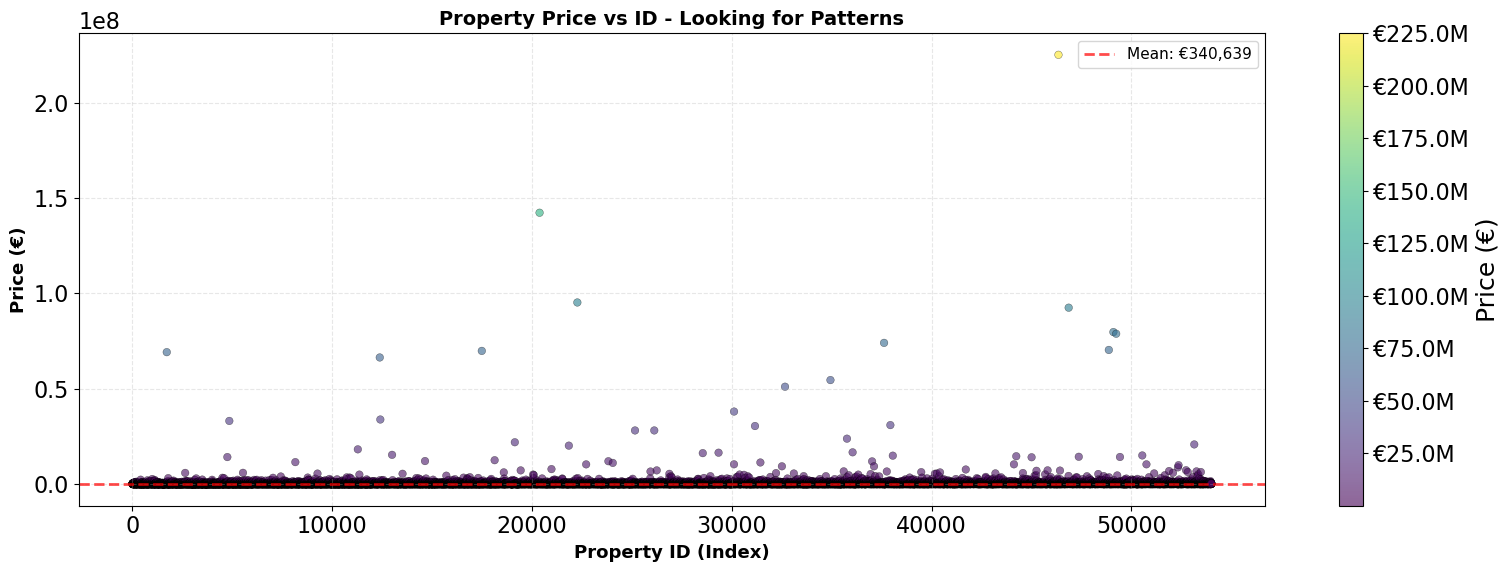

✓ Scatter plot generated successfully

Pattern Analysis:
- Check if prices are randomly distributed or show trends by ID
- Look for price clusters or gradients across IDs
- Identify any outliers or unusual patterns


In [15]:
# Price (€) vs ID relationship - Scatter plot analysis
print("="*70)
print("Price (€) vs Property ID - Pattern Analysis")
print("="*70)
print(f"Data type: {df['Price (€)'].dtype}")
print(f"Non-null count: {df['Price (€)'].notna().sum()}")
print(f"Min value: €{df['Price (€)'].min():,.2f}")
print(f"Max value: €{df['Price (€)'].max():,.2f}")
print(f"Mean value: €{df['Price (€)'].mean():,.2f}")
print(f"Median value: €{df['Price (€)'].median():,.2f}")
print(f"Std Dev: €{df['Price (€)'].std():,.2f}")
print("="*70 + "\n")

# Create scatter plot: ID on X-axis, Price on Y-axis to spot patterns
fig, ax = plt.subplots(figsize=(16, 6))

# Create scatter plot with color gradient
scatter = ax.scatter(df.index, df['Price (€)'], 
                    alpha=0.6, s=30, 
                    c=df['Price (€)'], cmap='viridis', 
                    edgecolor='black', linewidth=0.3)

ax.set_xlabel('Property ID (Index)', fontsize=13, fontweight='bold')
ax.set_ylabel('Price (€)', fontsize=13, fontweight='bold')
ax.set_title('Property Price vs ID - Looking for Patterns', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='both', linestyle='--')

# Add color bar to show price range
cbar = plt.colorbar(scatter, ax=ax, label='Price (€)')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1e6:.1f}M' if x >= 1e6 else f'€{x/1e3:.0f}K'))

# Add mean line
mean_price = df['Price (€)'].mean()
ax.axhline(y=mean_price, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: €{mean_price:,.0f}')
ax.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()

print("✓ Scatter plot generated successfully")
print("\nPattern Analysis:")
print("- Check if prices are randomly distributed or show trends by ID")
print("- Look for price clusters or gradients across IDs")
print("- Identify any outliers or unusual patterns")

From the histograms we can quickly see potential invalid data such as negative numbers (ClaimAmount < 0) or very large numbers (TotalClaimed > 700k) or many zeroes (IncomeofPolicyHolder). Another way to see outliers and potential errors is to look at boxplots for each feature.

Price (€) Distribution by Price Intervals - Boxplot Analysis

Price Interval Distribution:
Price_Interval
Very Low     53987
Low              9
Medium           2
High             1
Very High        1
Name: count, dtype: int64

Generating 5 separate boxplots for each price interval...



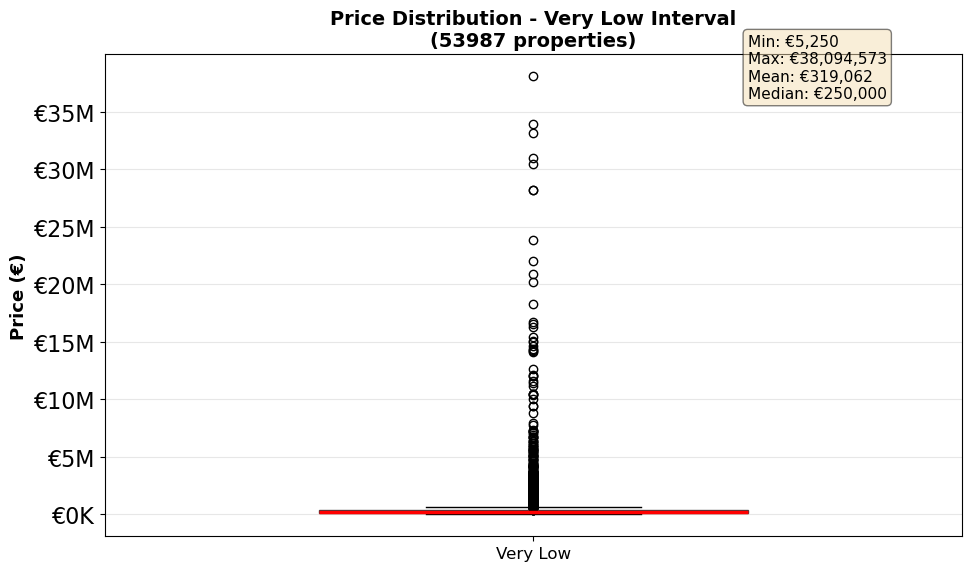

✓ Very Low interval: 53987 properties


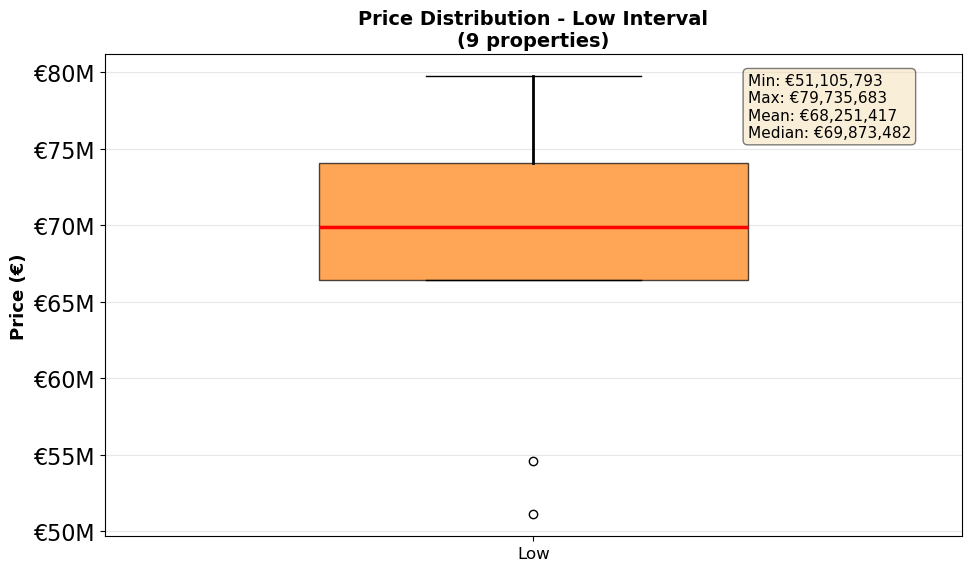

✓ Low interval: 9 properties


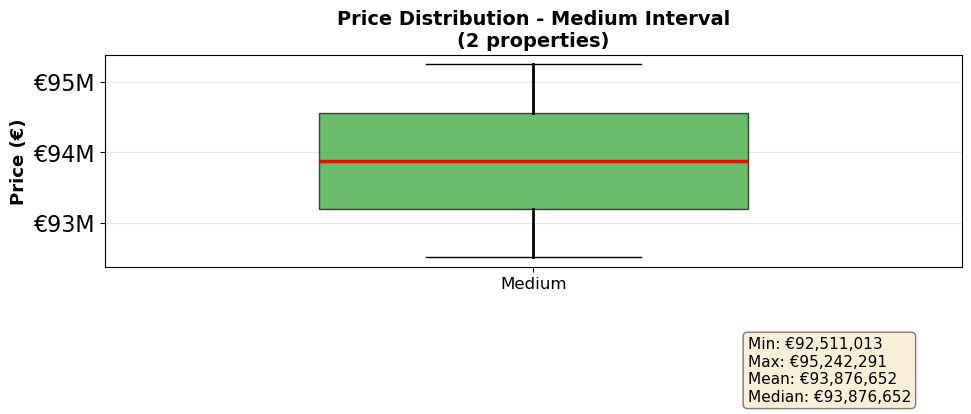

✓ Medium interval: 2 properties


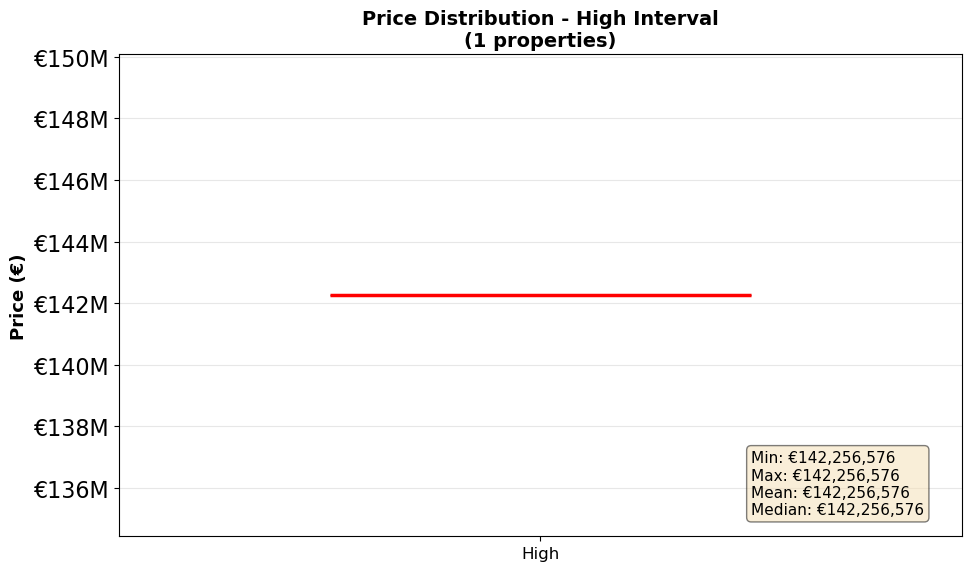

✓ High interval: 1 properties


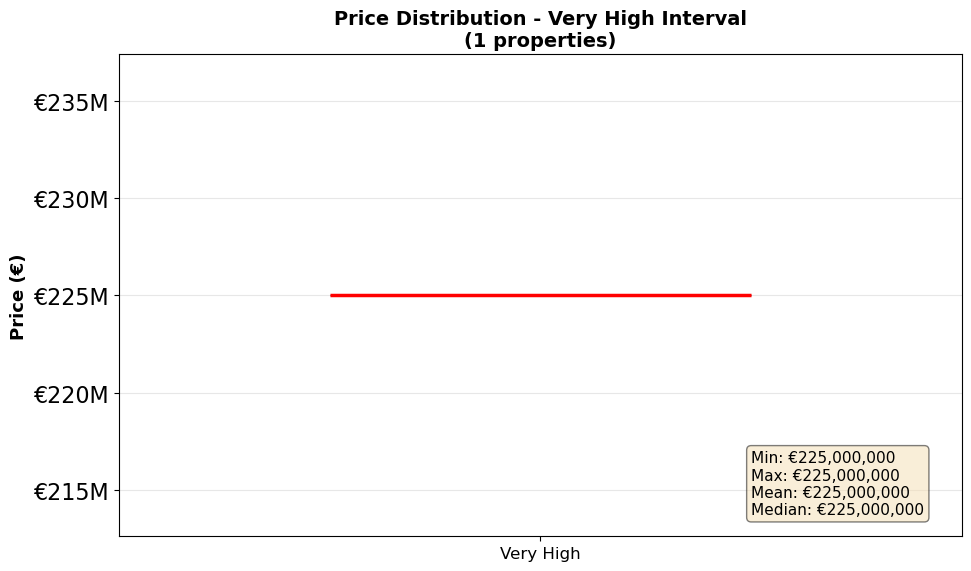

✓ Very High interval: 1 properties
All 5 boxplots generated successfully


In [12]:
# Boxplot: Price (€) distribution by price range intervals
# Create price intervals to see distribution patterns across price brackets

print("="*70)
print("Price (€) Distribution by Price Intervals - Boxplot Analysis")
print("="*70)

# Create price bins/intervals for analysis
# Define bins based on price quartiles or fixed intervals
df['Price_Interval'] = pd.cut(df['Price (€)'], 
                               bins=5,  # 5 intervals
                               labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Summary of intervals
print("\nPrice Interval Distribution:")
print(df['Price_Interval'].value_counts().sort_index())

# Create separate boxplots for each price interval to show distribution clearly
intervals = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

print("\nGenerating 5 separate boxplots for each price interval...\n")

for i, interval in enumerate(intervals):
    interval_data = df[df['Price_Interval'] == interval]['Price (€)']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bp = ax.boxplot(interval_data, vert=True, patch_artist=True, widths=0.5)
    
    # Style the boxplot
    bp['boxes'][0].set_facecolor(colors[i])
    bp['boxes'][0].set_alpha(0.7)
    bp['whiskers'][0].set_linewidth(2)
    bp['whiskers'][1].set_linewidth(2)
    bp['medians'][0].set_linewidth(2.5)
    bp['medians'][0].set_color('red')
    
    # Labels and title
    ax.set_ylabel('Price (€)', fontsize=13, fontweight='bold')
    ax.set_title(f'Price Distribution - {interval} Interval\n({len(interval_data)} properties)', 
                 fontsize=14, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x/1e6:.0f}M' if x >= 1e6 else f'€{x/1e3:.0f}K'))
    ax.grid(alpha=0.3, axis='y')
    ax.set_xticklabels([interval], fontsize=12)
    
    # Add statistics text box
    stats_text = f"Min: €{interval_data.min():,.0f}\nMax: €{interval_data.max():,.0f}\nMean: €{interval_data.mean():,.0f}\nMedian: €{interval_data.median():,.0f}"
    ax.text(1.25, interval_data.max()*0.95, stats_text, fontsize=11, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    print(f"✓ {interval} interval: {len(interval_data)} properties")

print("="*70)
print("All 5 boxplots generated successfully")
print("="*70)

In [26]:
# 爱尔兰房产数据 - 列出变量非空情况分析
print("="*80)
print("爱尔兰房产数据 - 变量非空情况 (Houses.ie Dataset)")
print("="*80)

# 逐列统计缺失值情况，参考格式：按照每列分别输出缺失计数和百分比
for col in df.columns:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    non_null_count = df[col].notna().sum()
    data_type = df[col].dtype
    
    print(f"\n{col} - 数据类型: {data_type}")
    print(f"  缺失值数量: {missing_count} ({missing_pct:.1f}%)")
    print(f"  非缺失值数量: {non_null_count} ({100 - missing_pct:.1f}%)")
    
    # 对于object/category类型，也显示非缺失值的计数
    if data_type == 'object' or data_type.name == 'category':
        value_counts = df[col].value_counts(dropna=False)
        if missing_count > 0:
            print(f"  值分布:")
            for val, count in value_counts.items():
                pct = (count / len(df)) * 100
                if pd.isna(val):
                    print(f"    NaN: {count} ({pct:.1f}%)")
                else:
                    print(f"    {val}: {count} ({pct:.1f}%)")

print("\n" + "="*80)
print("数据集汇总统计")
print("="*80)

total_cells = len(df) * len(df.columns)
total_null = df.isnull().sum().sum()
total_non_null = total_cells - total_null
overall_null_pct = (total_null / total_cells) * 100
overall_non_null_pct = 100 - overall_null_pct

print(f"\n数据集形状: {df.shape[0]} 行 × {df.shape[1]} 列")
print(f"总单元格数: {total_cells:,}")
print(f"总缺失数: {total_null}")
print(f"总非缺失数: {total_non_null:,}")
print(f"总体缺失比例: {overall_null_pct:.2f}%")
print(f"总体非缺失比例: {overall_non_null_pct:.2f}%")

# 统计有缺失值和无缺失值的列
cols_with_nulls = (df.isnull().sum() > 0).sum()
cols_without_nulls = (df.isnull().sum() == 0).sum()

print(f"\n有缺失值的列: {cols_with_nulls}")
print(f"无缺失值的列: {cols_without_nulls}")

# 识别缺失值严重的列（>50%）
critical_cols_mask = (df.isnull().sum() / len(df)) * 100 > 50
critical_cols = df.columns[critical_cols_mask].tolist()

if len(critical_cols) > 0:
    print(f"\n⚠️  严重缺失数据的列 (缺失 > 50%):")
    for col in critical_cols:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        print(f"   - {col}: {missing_pct:.1f}% 缺失 ({missing_count} 行)")
else:
    print(f"\n✓ 所有列的缺失比例都 <= 50%")

# 识别完全无缺失的列
complete_cols = df.columns[df.isnull().sum() == 0].tolist()
if len(complete_cols) > 0:
    print(f"\n✓ 完全无缺失的列 ({len(complete_cols)} 个):")
    for col in complete_cols:
        print(f"   - {col}")

print("\n" + "="*80)



爱尔兰房产数据 - 变量非空情况 (Houses.ie Dataset)

Date of Sale (dd/mm/yyyy) - 数据类型: object
  缺失值数量: 0 (0.0%)
  非缺失值数量: 54000 (100.0%)

Address - 数据类型: object
  缺失值数量: 0 (0.0%)
  非缺失值数量: 54000 (100.0%)

County - 数据类型: object
  缺失值数量: 0 (0.0%)
  非缺失值数量: 54000 (100.0%)

Eircode - 数据类型: object
  缺失值数量: 37108 (68.7%)
  非缺失值数量: 16892 (31.3%)
  值分布:
    NaN: 37108 (68.7%)
    D24W9NN: 4 (0.0%)
    Y25KH77: 2 (0.0%)
    A96E086: 2 (0.0%)
    D6WFC03: 2 (0.0%)
    D07Y589: 2 (0.0%)
    Y21VX96: 2 (0.0%)
    F31VP21: 2 (0.0%)
    F56Y183: 2 (0.0%)
    X35V308: 2 (0.0%)
    E25TK53: 2 (0.0%)
    R45FX24: 2 (0.0%)
    K67DP68: 2 (0.0%)
    V94YP74: 2 (0.0%)
    A96Y6X8: 2 (0.0%)
    A98AC03: 2 (0.0%)
    F92XC03: 2 (0.0%)
    A98P2Y2: 2 (0.0%)
    A94X0F6: 2 (0.0%)
    R95E4P1: 2 (0.0%)
    V92Y58R: 2 (0.0%)
    D06FW60: 2 (0.0%)
    X91CX93: 2 (0.0%)
    C15F5P0: 2 (0.0%)
    W91Y778: 2 (0.0%)
    H91C5F6: 2 (0.0%)
    A82AE06: 2 (0.0%)
    N39YR29: 2 (0.0%)
    C15XH98: 2 (0.0%)
    X34T886: 2 (0.0%)
    E3

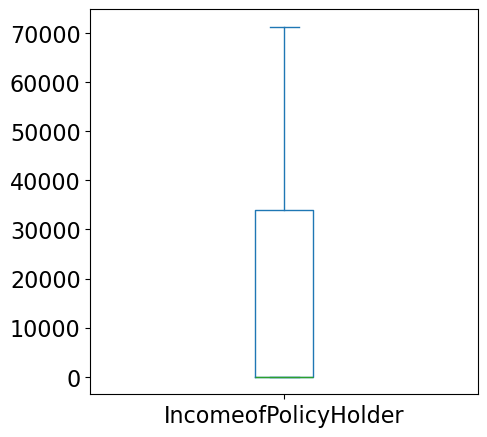

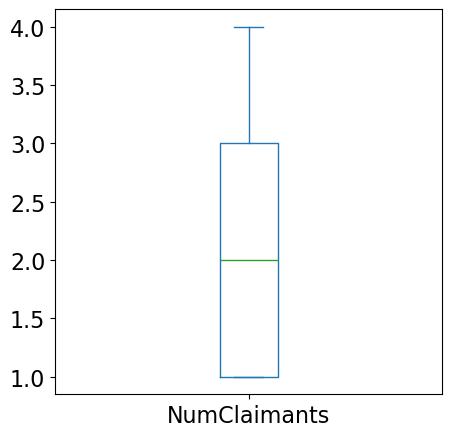

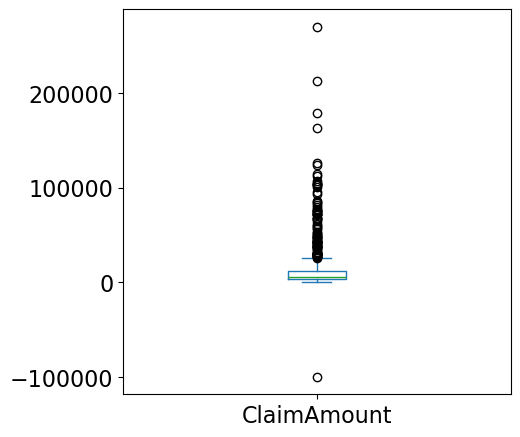

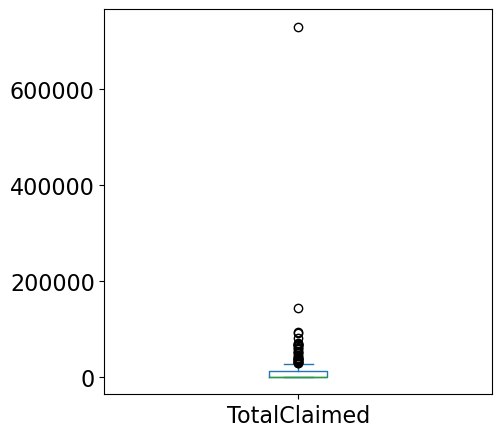

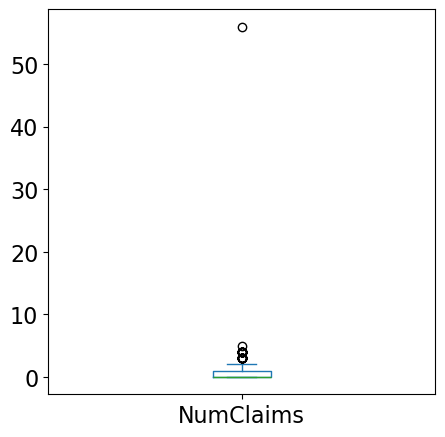

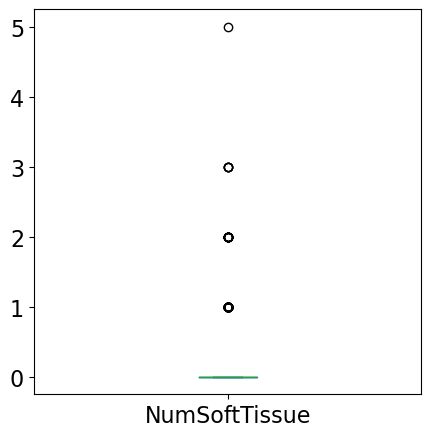

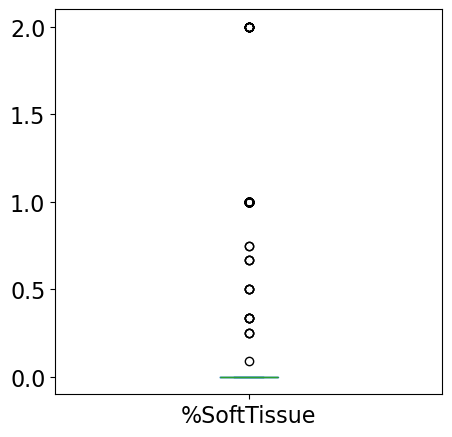

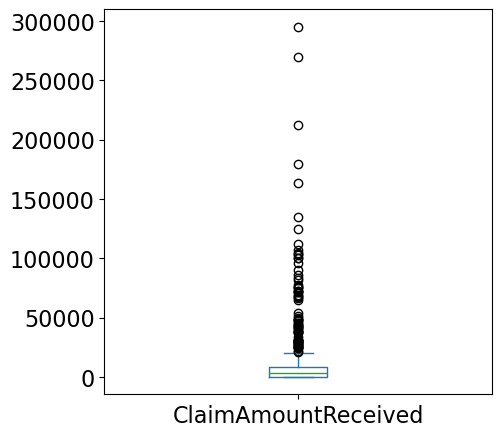

In [ ]:
# One boxplot per numeric feature, saved to a single PDF
pp = PdfPages('MotorInsurance-DataQualityReport-NumericFeatures_boxplots_1-1.pdf')

for col in numeric_columns:
    f = df[col].plot(kind='box', figsize=(5,5))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

From the boxplots we can quickly see outliers in some of the features (TotalClaimed and NumClaims).

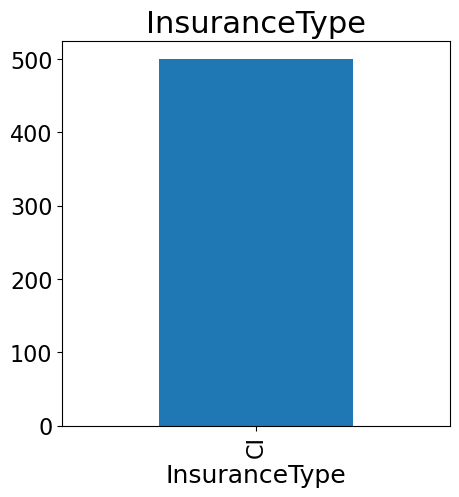

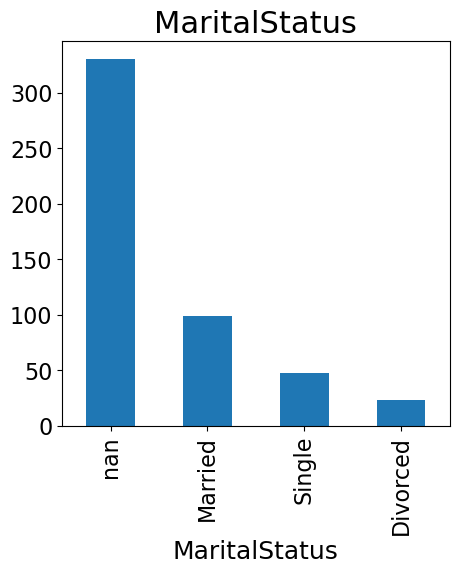

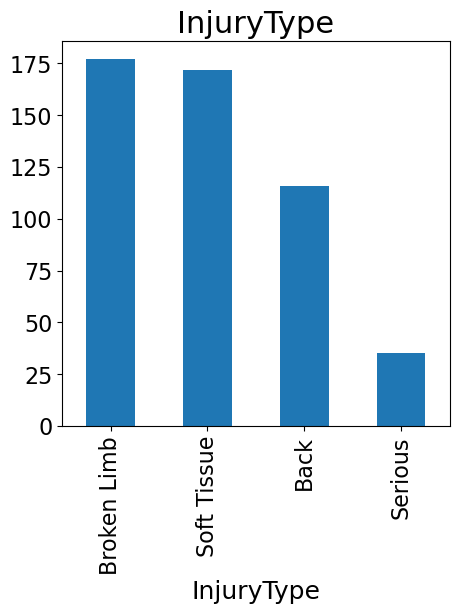

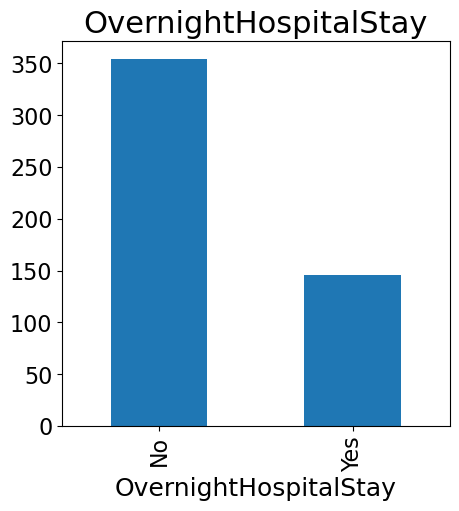

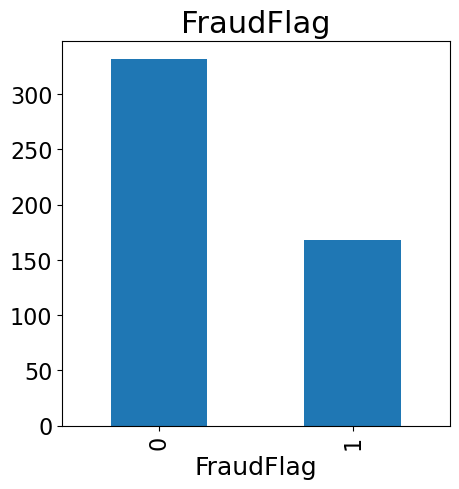

In [ ]:
# Bar charts for all categorical features (saved to a single PDF)
# dropna=False keeps missing values visible
pp = PdfPages('MotorInsurance-DataQualityReport-CategoricalFeatures_barcharts_1-1.pdf')

for column in category_columns:
    f = df[column].value_counts(dropna=False).plot(kind='bar', title=column, figsize=(5,5))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

From the barplots of categorical features we note that InsuranceType has a cardinality of 1 and that MaritalStatus has many missing values. We summarise all the findings from tables and plots in the data quality plan below.

### Section 1 + Visualisations: Key Findings (Summary)

- Data loaded with expected shape; feature types aligned with Lab3.
- Numeric plots show skew and outliers (e.g., TotalClaimed, NumClaims).
- Categorical plots show imbalance and missingness (e.g., InsuranceType, MaritalStatus).

These findings feed the Data Quality Plan.

## Section 2: Data Quality Plan

A Data Quality Plan documents issues, impact, and actions per feature.

For each feature, record:
- Type
- Issue(s)
- Impact
- Decision (keep, drop, impute, clamp)

Decision guide:
1. Can we fix it safely?
2. Is the feature useful?
3. What is the cost of removal?

### Detailed Motor Insurance Data Quality Plan

Based on the Lab3 findings, here is our comprehensive plan for handling each feature:

| Feature | Type | Data Quality Issue(s) | Impact | Root Cause Analysis | Proposed Solution | Final Action |
|---------|------|----------------------|--------|-------------------|------------------|--------------|
| **ID** | object | Unique identifier for each row | Low | By design | Keep for record linkage only | Keep, but exclude from modeling |
| **InsuranceType** | category | Constant feature - only 1 unique value | High | All records from same policy type | No variance = no predictive information | **DROP** - Constant feature |
| **IncomeofPolicyHolder** | int64 | 66% of values are 0; negatively correlated with MaritalStatus;implicitly missing data | High | Likely data entry missing representation; 0 used as placeholder for missing | Investigate: zeros represent missing MaritalStatus data | **DROP** - Too many missing values (66%) |
| **MaritalStatus** | category | 66% missing values (330 out of 500 records) | High | Data not collected for all records; correlates with IncomeofPolicyHolder=0 | Too many missing to impute reliably. Check if predictive of FraudFlag before dropping | **DROP** - Excessive missing data |
| **NumClaimants** | int64 | None identified | Low | Standard claim data | Feature appears clean, well-distributed | **KEEP** - No issues |
| **InjuryType** | category | None identified after examining value distribution | Low | Standard categorical feature | Categorical distribution looks reasonable | **KEEP** - No issues |
| **OvernightHospitalStay** | category | None identified | Low | Binary categorical feature | Clean data, balanced classes | **KEEP** - No issues |
| **ClaimAmount** | int64 | One negative value (-99,999.0); High outliers (75k+ values) | Medium | -99,999 likely error code for missing/invalid; High values are extreme but valid outliers | Investigate negative value; Clamp high outliers to 95th percentile (~75k) | **Correct** -99999 → 572; **Clamp** to 95th percentile |
| **TotalClaimed** | int64 | One extreme outlier (729,560 >> typical ~50-100k range) | Medium | One record appears to be company claim (see textbook) rather than individual | Investigate the extreme value row; if company record, remove | **DROP** - 1 row with invalid company claim |
| **NumClaims** | int64 | One extreme outlier (>50 claims when others ≤5) | Medium | Same row as TotalClaimed outlier - likely company vs individual | Related to the row already flagged for removal | Covered by dropping row with TotalClaimed outlier |
| **NumSoftTissue** | float64 | 10 missing values (2%); Missing values occur when %SoftTissue=0 | Low | Pattern suggests 0 should mean no soft tissue cases (not missing) | Replace NaN with 0 based on pattern with %SoftTissue | **Impute** - Replace NaN with 0 |
| **%SoftTissue** | float64 | None identified | Low | Appears to be percentage when soft tissue exists | Looks reasonable given correlation with NumSoftTissue | **KEEP** - No issues |
| **ClaimAmountReceived** | int64 | No negative values found; Some zero values | Low | Valid values; zeros represent $0 received | Keep as-is; represents business logic (fraud = no payment) | **KEEP** - No issues |
| **FraudFlag** | category | Imbalanced target: 66% non-fraud (0), 34% fraud (1) | Low | Natural class imbalance in fraud data (fraud is rarer) | This is expected in fraud detection; address in modeling stage | **KEEP** - Deal with imbalance in modeling |

**Summary of Actions:**
- **DROP 3 features**: InsuranceType (constant), IncomeofPolicyHolder (66% missing), MaritalStatus (66% missing)
- **DROP 1 row**: Company claim with TotalClaimed=729,560
- **CORRECT 1 value**: ClaimAmount: -99,999 → 572
- **CLAMP 25 values**: ClaimAmount values > 75th percentile clamped to 75th percentile
- **IMPUTE 10 values**: NumSoftTissue NaN values → 0
- **Result**: 499 rows × 11 features ready for modeling

## Section 3: Implementation of Data Quality Strategies

We apply the plan in this order:
1. Backup
2. Drop problematic features
3. Fix invalid values and remove extreme rows
4. Clamp outliers
5. Impute missing values
6. Validate and save

In [ ]:
# Step 1: Create a backup of the original unmodified data
# This allows us to compare and validate our transformations later
df_raw = df.copy()

print("="*70)
print("BACKUP CREATED")
print("="*70)
print(f"Original dataset preserved with shape: {df_raw.shape}")
print(f"Rows: {df_raw.shape[0]}, Columns: {df_raw.shape[1]}")
print(f"Columns: {list(df_raw.columns)}")
print("="*70)

BACKUP CREATED
Original dataset preserved with shape: (500, 14)
Rows: 500, Columns: 14
Columns: ['ID', 'InsuranceType', 'IncomeofPolicyHolder', 'MaritalStatus', 'NumClaimants', 'InjuryType', 'OvernightHospitalStay', 'ClaimAmount', 'TotalClaimed', 'NumClaims', 'NumSoftTissue', '%SoftTissue', 'ClaimAmountReceived', 'FraudFlag']


### Step 2: Investigate and Drop Problematic Features

We verify the three problematic features identified in Lab3 (constant or excessive missingness), then drop them in one step.
The code below documents the checks and the final drop operation.

In [ ]:
# Step 2a: Verify the problematic features exist and analyse them before dropping
print("Analysis of Features to Drop:")
print("-" * 70)

# Analyze InsuranceType
print("\n1. InsuranceType - Cardinality Check:")
print(f"   Number of unique values: {df['InsuranceType'].nunique()}")
print(f"   Values: {df['InsuranceType'].unique()}")
print("   → Decision: CONSTANT FEATURE - DROP")

# Analyze IncomeofPolicyHolder
print("\n2. IncomeofPolicyHolder - Missing Data Check:")
zeros_count = (df['IncomeofPolicyHolder'] == 0).sum() #0值
missing_count = df['IncomeofPolicyHolder'].isnull().sum() #缺失
total_problematic = zeros_count + missing_count
pct_problematic = 100 * total_problematic / len(df)
print(f"   Number of zeros: {zeros_count}")
print(f"   Number of NaN: {missing_count}")
print(f"   Total problematic values: {total_problematic} ({pct_problematic:.1f}%)")
print("   → Decision: TOO MANY MISSING VALUES - DROP")

# Analyze MaritalStatus
print("\n3. MaritalStatus - Missing Data check:")
missing_count = df['MaritalStatus'].isnull().sum()
pct_missing = 100 * missing_count / len(df)
print(f"   Number of missing values: {missing_count} ({pct_missing:.1f}%)")
print(f"   Non-missing value counts:")
print(f"   {df['MaritalStatus'].value_counts(dropna=False)}")
print("   → Decision: EXCESSIVE MISSING DATA - DROP")

print("\n" + "="*70)
print("DROPPING FEATURES")
print("="*70)

# Drop the problematic columns
features_to_drop = ['InsuranceType', 'IncomeofPolicyHolder', 'MaritalStatus']
df = df.drop(features_to_drop, axis=1)# 执行删除

print(f"\n✓ Successfully dropped {len(features_to_drop)} features:")
for feat in features_to_drop:
    print(f"  - {feat}")
print(f"\nDataset shape after dropping features: {df.shape}")
print(f"Remaining columns ({df.shape[1]}): {list(df.columns)}")

# CRITICAL: Update feature column references after dropping columns
numeric_columns = df.select_dtypes(['int64', 'float64']).columns
category_columns = df.select_dtypes('category').columns
print(f"\n✓ Updated feature references:")
print(f"  Numeric columns: {list(numeric_columns)}")
print(f"  Category columns: {list(category_columns)}")

Analysis of Features to Drop:
----------------------------------------------------------------------

1. InsuranceType - Cardinality Check:
   Number of unique values: 1
   Values: ['CI']
Categories (1, object): ['CI']
   → Decision: CONSTANT FEATURE - DROP

2. IncomeofPolicyHolder - Missing Data Check:
   Number of zeros: 330
   Number of NaN: 0
   Total problematic values: 330 (66.0%)
   → Decision: TOO MANY MISSING VALUES - DROP

3. MaritalStatus - Missing Data check:
   Number of missing values: 330 (66.0%)
   Non-missing value counts:
   MaritalStatus
NaN         330
Married      99
Single       48
Divorced     23
Name: count, dtype: int64
   → Decision: EXCESSIVE MISSING DATA - DROP

DROPPING FEATURES

✓ Successfully dropped 3 features:
  - InsuranceType
  - IncomeofPolicyHolder
  - MaritalStatus

Dataset shape after dropping features: (500, 11)
Remaining columns (11): ['ID', 'NumClaimants', 'InjuryType', 'OvernightHospitalStay', 'ClaimAmount', 'TotalClaimed', 'NumClaims', 'NumSo

### Step 3: Investigate and Correct Remaining Data Issues

With the problematic features removed, we focus on remaining issues:
- Extreme outliers in `TotalClaimed` and `NumClaims`
- Negative or invalid values in `ClaimAmount`
- Small pockets of missing values (e.g., `NumSoftTissue`)

The next cells investigate these issues and apply corrections in a reproducible way.

In [ ]:
# Investigation 1: Extreme Outliers - TotalClaimed
# From Lab3 findings, we identified an extreme value (729,560) far above typical range (50-100k)

print("="*70)
print("Investigation 1: Extreme Outlier in TotalClaimed")
print("="*70)

extreme_claimed = df[df['TotalClaimed'] > 200000]

if len(extreme_claimed) > 0:
    print(f"\nFound {len(extreme_claimed)} row(s) with TotalClaimed > 200,000")
    print("\nDetails of extreme value(s):")
    display(extreme_claimed)
    print("\nAnalysis:")
    print("- This value (729,560) is ~10x the typical maximum")
    print("- According to textbook, this appears to be a company claim (not individual)")
    print("- Individual claims should be < 100k")
    print("- Decision: REMOVE this row - invalid for individual claim modeling")
else:
    print("\nNo extreme outliers in TotalClaimed found")
    

# Investigation 2: Extreme Outliers - NumClaims
print("\n" + "="*70)
print("Investigation 2: Extreme Outlier in NumClaims")
print("="*70)

extreme_numclaims = df[df['NumClaims'] > 30]

if len(extreme_numclaims) > 0:
    print(f"\nFound {len(extreme_numclaims)} row(s) with NumClaims > 30")
    print("\nDetails:")
    display(extreme_numclaims)
    print("\nAnalysis:")
    print("- Typical range: 1-5 claims per individual")
    print("- Value >50 suggests company claim, not individual")
    print("- This is same row as TotalClaimed outlier")
    print("- Decision: Will be removed when we drop the TotalClaimed outlier row")
else:
    print("\nNo extreme outliers in NumClaims found")

Investigation 1: Extreme Outlier in TotalClaimed

Found 1 row(s) with TotalClaimed > 200,000

Details of extreme value(s):


,ID,NumClaimants,InjuryType,OvernightHospitalStay,ClaimAmount,TotalClaimed,NumClaims,NumSoftTissue,%SoftTissue,ClaimAmountReceived,FraudFlag
21,22,3,Back,No,8688,729792,56,5.0,0.089286,8688,0



Analysis:
- This value (729,560) is ~10x the typical maximum
- According to textbook, this appears to be a company claim (not individual)
- Individual claims should be < 100k
- Decision: REMOVE this row - invalid for individual claim modeling

Investigation 2: Extreme Outlier in NumClaims

Found 1 row(s) with NumClaims > 30

Details:


,ID,NumClaimants,InjuryType,OvernightHospitalStay,ClaimAmount,TotalClaimed,NumClaims,NumSoftTissue,%SoftTissue,ClaimAmountReceived,FraudFlag
21,22,3,Back,No,8688,729792,56,5.0,0.089286,8688,0



Analysis:
- Typical range: 1-5 claims per individual
- Value >50 suggests company claim, not individual
- This is same row as TotalClaimed outlier
- Decision: Will be removed when we drop the TotalClaimed outlier row


In [ ]:
# Drop the row(s) with extreme outliers
print("Dropping rows with invalid data...")
print(f"Shape before dropping: {df.shape}")

# Get the indices of rows to drop
rows_to_drop = df[df['TotalClaimed'] > 700000].index #定义删除目标
if len(rows_to_drop) > 0:
    print(f"Dropping {len(rows_to_drop)} row(s):")
    print(f"  Indices: {list(rows_to_drop)}")
    df = df.drop(rows_to_drop) #删除

print(f"Shape after dropping: {df.shape}")
print(f"✓ Successfully removed {len(rows_to_drop)} invalid row(s)")

Dropping rows with invalid data...
Shape before dropping: (500, 11)
Dropping 1 row(s):
  Indices: [21]
Shape after dropping: (499, 11)
✓ Successfully removed 1 invalid row(s)


#### Investigation 3: Negative Values in ClaimAmount

Negative values should not exist for claim amounts. We need to investigate:

#### Action: Correct Negative ClaimAmount Values

The negative value (-99,999) appears to be an error code for missing/invalid data. We'll correct it:

ClaimAmount and ClaimAmountReceived seem to have same value for all cases with FraudFlag=0. 
We will replace the negative value with the ClaimAmountReceived value.


In [ ]:
# Find the rows with negative ClaimAmount
print("="*70)
print("Checking for Negative ClaimAmount Values")
print("="*70)

negative_claims = df[df['ClaimAmount'] < 0]

if len(negative_claims) > 0:
    print(f"\nFound {len(negative_claims)} row(s) with negative ClaimAmount:")
    print("\nBefore correction:")
    display(negative_claims)
    
    print("\nAnalysis:")
    print("- Value -99,999 appears to be an error code (not a real negative amount)")
    print("- For fraud cases (FraudFlag=0): ClaimAmount typically equals ClaimAmountReceived")
    
    # Check the value in ClaimAmountReceived for this row
    row_idx = negative_claims.index[0] #获取目标行索引
    claim_amt_received = df.loc[row_idx, 'ClaimAmountReceived']# 提取真实值
    print(f"- For this row: ClaimAmountReceived = {claim_amt_received}")
    print(f"- Decision: Replace -99,999 with {claim_amt_received}")
    
    # Replace the negative value with the corresponding received amount
    df['ClaimAmount'] = df['ClaimAmount'].replace(-99999, claim_amt_received)# 替换错误值
    
    print("\nAfter correction:")
    display(df.loc[negative_claims.index])
    print(f"\n✓ Negative value corrected")
else:
    print("\n✓ No negative ClaimAmount values found")

Checking for Negative ClaimAmount Values

Found 1 row(s) with negative ClaimAmount:

Before correction:


,ID,NumClaimants,InjuryType,OvernightHospitalStay,ClaimAmount,TotalClaimed,NumClaims,NumSoftTissue,%SoftTissue,ClaimAmountReceived,FraudFlag
2,3,1,Broken Limb,No,-99999,0,0,0.0,0.0,572,0



Analysis:
- Value -99,999 appears to be an error code (not a real negative amount)
- For fraud cases (FraudFlag=0): ClaimAmount typically equals ClaimAmountReceived
- For this row: ClaimAmountReceived = 572
- Decision: Replace -99,999 with 572

After correction:


,ID,NumClaimants,InjuryType,OvernightHospitalStay,ClaimAmount,TotalClaimed,NumClaims,NumSoftTissue,%SoftTissue,ClaimAmountReceived,FraudFlag
2,3,1,Broken Limb,No,572,0,0,0.0,0.0,572,0



✓ Negative value corrected


### Step 4: Handle Outliers - Clamp High ClaimAmount

We cap extreme values in `ClaimAmount` at the 95th percentile to reduce distortion while preserving all rows. This keeps the feature interpretable while limiting the influence of very large claims.

In [ ]:
# Clamp extreme ClaimAmount values at the 95th percentile
perc95 = np.percentile(df['ClaimAmount'], 95)

outlier_mask = df['ClaimAmount'] > perc95 #定义范围
num_outliers = int(outlier_mask.sum())

if num_outliers > 0:
    df.loc[outlier_mask, 'ClaimAmount'] = perc95 # 限制超出95百分位的值为95百分位值

print("ClaimAmount clamping summary")
print(f"  95th percentile threshold: {perc95:,.2f}")
print(f"  Values clamped: {num_outliers}")
print(f"  Data affected: {100 * num_outliers / len(df):.1f}%")

the outlier value has 25
ClaimAmount clamping summary
  95th percentile threshold: 75,619.00
  Values clamped: 25
  Data affected: 5.0%


<Axes: >

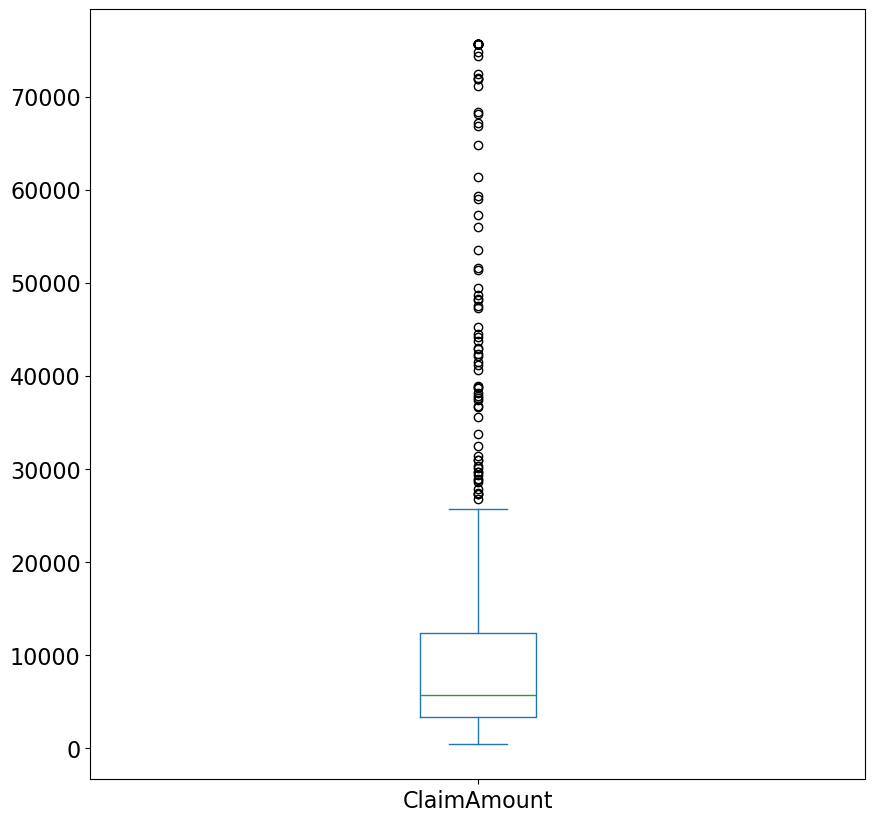

In [ ]:
# Replot the clamped feature
df['ClaimAmount'].plot(kind='box', figsize=(10,10))

### Step 5: Impute Missing Values (NumSoftTissue)

`NumSoftTissue` has a small number of missing values and the pattern aligns with `%SoftTissue = 0`. We replace those NaNs with 0 to reflect no soft tissue cases.

In [ ]:
print("="*70)
print("Handling Missing Values: NumSoftTissue")
print("="*70)

# Analyze missing values
missing_indices = df[df['NumSoftTissue'].isnull()].index
num_missing = len(missing_indices)

print(f"\nMissing value analysis:")
print(f"Total missing values: {num_missing}")
print(f"Percentage missing: {100*num_missing/len(df):.1f}%")

if num_missing > 0:
    print(f"\nExamining rows with missing NumSoftTissue:")
    print("Before imputation:")
    display(df.loc[missing_indices, ['NumSoftTissue', '%SoftTissue', 'NumClaimants']])

    print("\nPattern observation:")
    print("- All rows with missing NumSoftTissue have %SoftTissue = 0")
    print("- This indicates no soft tissue injuries = 0 cases")
    print("- Decision: Impute NaN with 0")

    # Perform imputation
    df['NumSoftTissue'] = df['NumSoftTissue'].replace(np.nan, 0)

    print("\nAfter imputation:")
    display(df.loc[missing_indices, ['NumSoftTissue', '%SoftTissue', 'NumClaimants']])
    print(f"\n✓ Imputed {num_missing} missing values with 0")
else:
    print("\n✓ No missing NumSoftTissue values found")

# Final check
if df['NumSoftTissue'].isnull().sum() == 0:
    print("\n✓ All missing values handled successfully")

print("="*70)

Handling Missing Values: NumSoftTissue

Missing value analysis:
Total missing values: 10
Percentage missing: 2.0%

Examining rows with missing NumSoftTissue:
Before imputation:


,NumSoftTissue,%SoftTissue,NumClaimants
8,NaN,0.0,1
26,NaN,0.0,3
146,NaN,0.0,1
149,NaN,0.0,2
220,NaN,0.0,2
404,NaN,0.0,2
422,NaN,0.0,3
479,NaN,0.0,1
492,NaN,0.0,1
496,NaN,0.0,4



Pattern observation:
- All rows with missing NumSoftTissue have %SoftTissue = 0
- This indicates no soft tissue injuries = 0 cases
- Decision: Impute NaN with 0

After imputation:


,NumSoftTissue,%SoftTissue,NumClaimants
8,0.0,0.0,1
26,0.0,0.0,3
146,0.0,0.0,1
149,0.0,0.0,2
220,0.0,0.0,2
404,0.0,0.0,2
422,0.0,0.0,3
479,0.0,0.0,1
492,0.0,0.0,1
496,0.0,0.0,4



✓ Imputed 10 missing values with 0

✓ All missing values handled successfully


## Section 4: Validation & Summary

### Step 6: Validate Cleaned Dataset

After implementing all data quality strategies, we validate that:
1. All identified issues have been resolved
2. No new issues were introduced during cleaning
3. Data types are correct
4. No remaining missing values (except where appropriate)
5. Dataset is ready for modeling

In [ ]:
print("="*70)
print("DATA QUALITY VALIDATION - FINAL CHECKS")
print("="*70)

# Comparison: Before vs After
print("\n1. DATASET DIMENSIONS COMPARISON")
print("-" * 70)
print(f"Original dataset (from Lab3):")
print(f"  Rows: {df_raw.shape[0]}, Columns: {df_raw.shape[1]}")
print(f"\nCleaned dataset:")
print(f"  Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"\nChanges:")
print(f"  Rows removed: {df_raw.shape[0] - df.shape[0]} (1 invalid company claim)")
print(f"  Columns dropped: {df_raw.shape[1] - df.shape[1]} (3 problematic features)")

# Check for missing values
print("\n2. MISSING VALUES CHECK")
print("-" * 70)
missing_summary = df.isnull().sum()
if missing_summary.sum() == 0:
    print("✓ All missing values processed successfully - NONE remaining")
else:
    print("⚠ WARNING: Remaining missing values found:")
    print(missing_summary[missing_summary > 0])

# Check data types
print("\n3. DATA TYPES CHECK")
print("-" * 70)
print("Remaining features and their types:")
df.info()

# Check for remaining obviously problematic values
print("\n4. VALUE RANGE VALIDATION")
print("-" * 70)

# Check for negative values in amount columns
for col in ['ClaimAmount', 'ClaimAmountReceived', 'TotalClaimed']:
    if col in df.columns:
        negatives = (df[col] < 0).sum()
        if negatives > 0:
            print(f"⚠ WARNING: {negatives} negative values in {col}")
        else:
            print(f"✓ {col}: No negative values")

# Check for duplicates
print("\n5. DUPLICATE CHECK")
print("-" * 70)
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")
if dup_count == 0:
    print("✓ No duplicate rows found")
else:
    print(f"⚠ WARNING: {dup_count} duplicate rows detected")

print("\n" + "="*70)
print("VALIDATION COMPLETE")
print("="*70)

DATA QUALITY VALIDATION - FINAL CHECKS

1. DATASET DIMENSIONS COMPARISON
----------------------------------------------------------------------
Original dataset (from Lab3):
  Rows: 500, Columns: 14

Cleaned dataset:
  Rows: 499, Columns: 11

Changes:
  Rows removed: 1 (1 invalid company claim)
  Columns dropped: 3 (3 problematic features)

2. MISSING VALUES CHECK
----------------------------------------------------------------------
✓ All missing values processed successfully - NONE remaining

3. DATA TYPES CHECK
----------------------------------------------------------------------
Remaining features and their types:
<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ID                     499 non-null    object  
 1   NumClaimants           499 non-null    int64   
 2   InjuryType             499 non-null    category
 3   Ove

In [ ]:
# Stats for numeric features.
df.describe(include=['int', 'float']).T

,count,mean,std,min,25%,50%,75%,max
NumClaimants,499.0,1.905812,1.012545,1.0,1.0,2.0,3.0,4.0
ClaimAmount,499.0,14640.359719,20654.315863,385.0,3311.5,5658.0,12306.0,75631.9
TotalClaimed,499.0,8153.909820,15174.529615,0.0,0.0,0.0,11171.5,144000.0
NumClaims,499.0,0.687375,0.997215,0.0,0.0,0.0,1.0,5.0
NumSoftTissue,499.0,0.220441,0.544692,0.0,0.0,0.0,0.0,3.0
%SoftTissue,499.0,0.172178,0.428429,0.0,0.0,0.0,0.0,2.0
ClaimAmountReceived,499.0,13060.687375,30577.222793,0.0,0.0,3238.0,8118.0,295303.0


### Summary: Numeric and Categorical Features After Cleaning

In [ ]:
# Stats for category features.
df.describe(include="category").T

,count,unique,top,freq
InjuryType,499,4,Broken Limb,177
OvernightHospitalStay,499,2,No,353
FraudFlag,499,2,0,331


In [ ]:
df.nunique()

ID                       499
NumClaimants               4
InjuryType                 4
OvernightHospitalStay      2
ClaimAmount              468
TotalClaimed             234
NumClaims                  6
NumSoftTissue              4
%SoftTissue                8
ClaimAmountReceived      328
FraudFlag                  2
dtype: int64

In [ ]:
df.isnull().sum()

ID                       0
NumClaimants             0
InjuryType               0
OvernightHospitalStay    0
ClaimAmount              0
TotalClaimed             0
NumClaims                0
NumSoftTissue            0
%SoftTissue              0
ClaimAmountReceived      0
FraudFlag                0
dtype: int64

All features seem ok now, no missing values or strange values.

3. **Clean Data.** Save the new data frame to a file with a name that reflects that the data has been cleaned.

In [ ]:
print("="*70)
print("SAVING CLEANED DATASET")
print("="*70)

# Define output filename with version indicator
output_filename = 'MotorInsuranceFraudClaimABTFull_Round1_Cleaned.csv' #定义输出文件名

# Write the cleaned dataframe to a csv file with UTF-8 encoding
df.to_csv(output_filename, index=False, encoding='utf-8') #执行保存

print(f"\n✓ Cleaned dataset saved successfully")
print(f"\nFile Information:")
print(f"  Filename: {output_filename}")
print(f"  Location: Current working directory")
print(f"  Format: CSV (UTF-8 encoding)")
print(f"  Rows: {df.shape[0]}")
print(f"  Columns: {df.shape[1]}")
print(f"\nDataset is now ready for:")
print(f"  - Data Exploration (relationships between features)")
print(f"  - Feature Engineering (creating derived features)")
print(f"  - Modeling (building predictive models)")
print("="*70)

SAVING CLEANED DATASET

✓ Cleaned dataset saved successfully

File Information:
  Filename: MotorInsuranceFraudClaimABTFull_Round1_Cleaned.csv
  Location: Current working directory
  Format: CSV (UTF-8 encoding)
  Rows: 499
  Columns: 11

Dataset is now ready for:
  - Data Exploration (relationships between features)
  - Feature Engineering (creating derived features)
  - Modeling (building predictive models)


## Section 5: Lab4 Summary

**What we did:**
- Dropped uninformative features
- Fixed invalid values
- Removed an extreme outlier row
- Clamped high ClaimAmount values
- Imputed small missing pockets

**Result:** clean dataset ready for modeling, with decisions documented.

### Step 7: Save Cleaned Dataset

Now that we've validated the cleaned data, we save it to a CSV file for use in data exploration, feature engineering, and modeling stages of the CRISP-DM process.

## Section 6: Exercises

1. Explain why MaritalStatus and InsuranceType were dropped.
2. Compare ClaimAmount distributions before vs after clamping.
3. Propose an alternative strategy for handling missing NumSoftTissue values.
4. How would you monitor data quality changes in production?

**Quick checklist:**
- Can you describe the Data Quality Plan structure?
- Can you justify each cleaning action?
- Can you summarize the final dataset readiness?

## Section 7: Exercise 2 - Compare ClaimAmount Before vs After Clamping

Visualize the effect of clamping on ClaimAmount distribution by comparing before and after statistics and distributions.


In [ ]:
# Exercise 2: Compare ClaimAmount Before vs After Clamping

print("="*80)
print("COMPARISON: ClaimAmount BEFORE vs AFTER Clamping")
print("="*80)

# Extract ClaimAmount from before and after
claim_before = df_raw['ClaimAmount']  # Original with negatives and high outliers
claim_after = df['ClaimAmount']       # After correction and clamping

print("\n1. SUMMARY STATISTICS COMPARISON")
print("-" * 80)

# Create comparison table
comparison_stats = pd.DataFrame({
    'Before Clamping': claim_before.describe(),
    'After Clamping': claim_after.describe()
})

print(comparison_stats)

print("\n2. PERCENTILE ANALYSIS")
print("-" * 80)

percentiles = [50, 75, 90, 95, 99]
percentile_comparison = pd.DataFrame({
    'Percentile': percentiles,
    'Before (Original)': [claim_before.quantile(p/100) for p in percentiles],
    'After (Clamped)': [claim_after.quantile(p/100) for p in percentiles]
})

percentile_comparison['Change'] = percentile_comparison['After (Clamped)'] - percentile_comparison['Before (Original)']
print(percentile_comparison.to_string(index=False))

print("\n3. OUTLIER DETECTION")
print("-" * 80)

# Count values above 95th percentile before clamping
threshold_95 = claim_before.quantile(0.95)
outliers_before = (claim_before > threshold_95).sum()
outliers_after = (claim_after > threshold_95).sum()

print(f"95th percentile threshold: ${threshold_95:,.2f}")
print(f"Values above 95th percentile before clamping: {outliers_before} ({100*outliers_before/len(claim_before):.1f}%)")
print(f"Values above 95th percentile after clamping: {outliers_after} ({100*outliers_after/len(claim_after):.1f}%)")

# Count extreme values (beyond 99th percentile)
threshold_99 = claim_before.quantile(0.99)
extreme_before = (claim_before > threshold_99).sum()
extreme_after = (claim_after > threshold_99).sum()

print(f"\n99th percentile threshold: ${threshold_99:,.2f}")
print(f"Extreme values (>99th percentile) before: {extreme_before}")
print(f"Extreme values (>99th percentile) after: {extreme_after}")

print("\n" + "="*80)


COMPARISON: ClaimAmount BEFORE vs AFTER Clamping

1. SUMMARY STATISTICS COMPARISON
--------------------------------------------------------------------------------
       Before Clamping  After Clamping
count        500.00000      499.000000
mean       16373.20400    14639.713427
std        29426.27696    20652.403653
min       -99999.00000      385.000000
25%         3322.25000     3311.500000
50%         5663.00000     5658.000000
75%        12245.50000    12306.000000
max       270200.00000    75619.000001

2. PERCENTILE ANALYSIS
--------------------------------------------------------------------------------
 Percentile  Before (Original)  After (Clamped)        Change
         50            5663.00      5658.000000     -5.000000
         75           12245.50     12306.000000     60.500000
         90           47568.10     47628.200000     60.100000
         95           75625.45     75619.000000     -6.450000
         99          124331.32     75619.000001 -48712.319999

3. OUTL

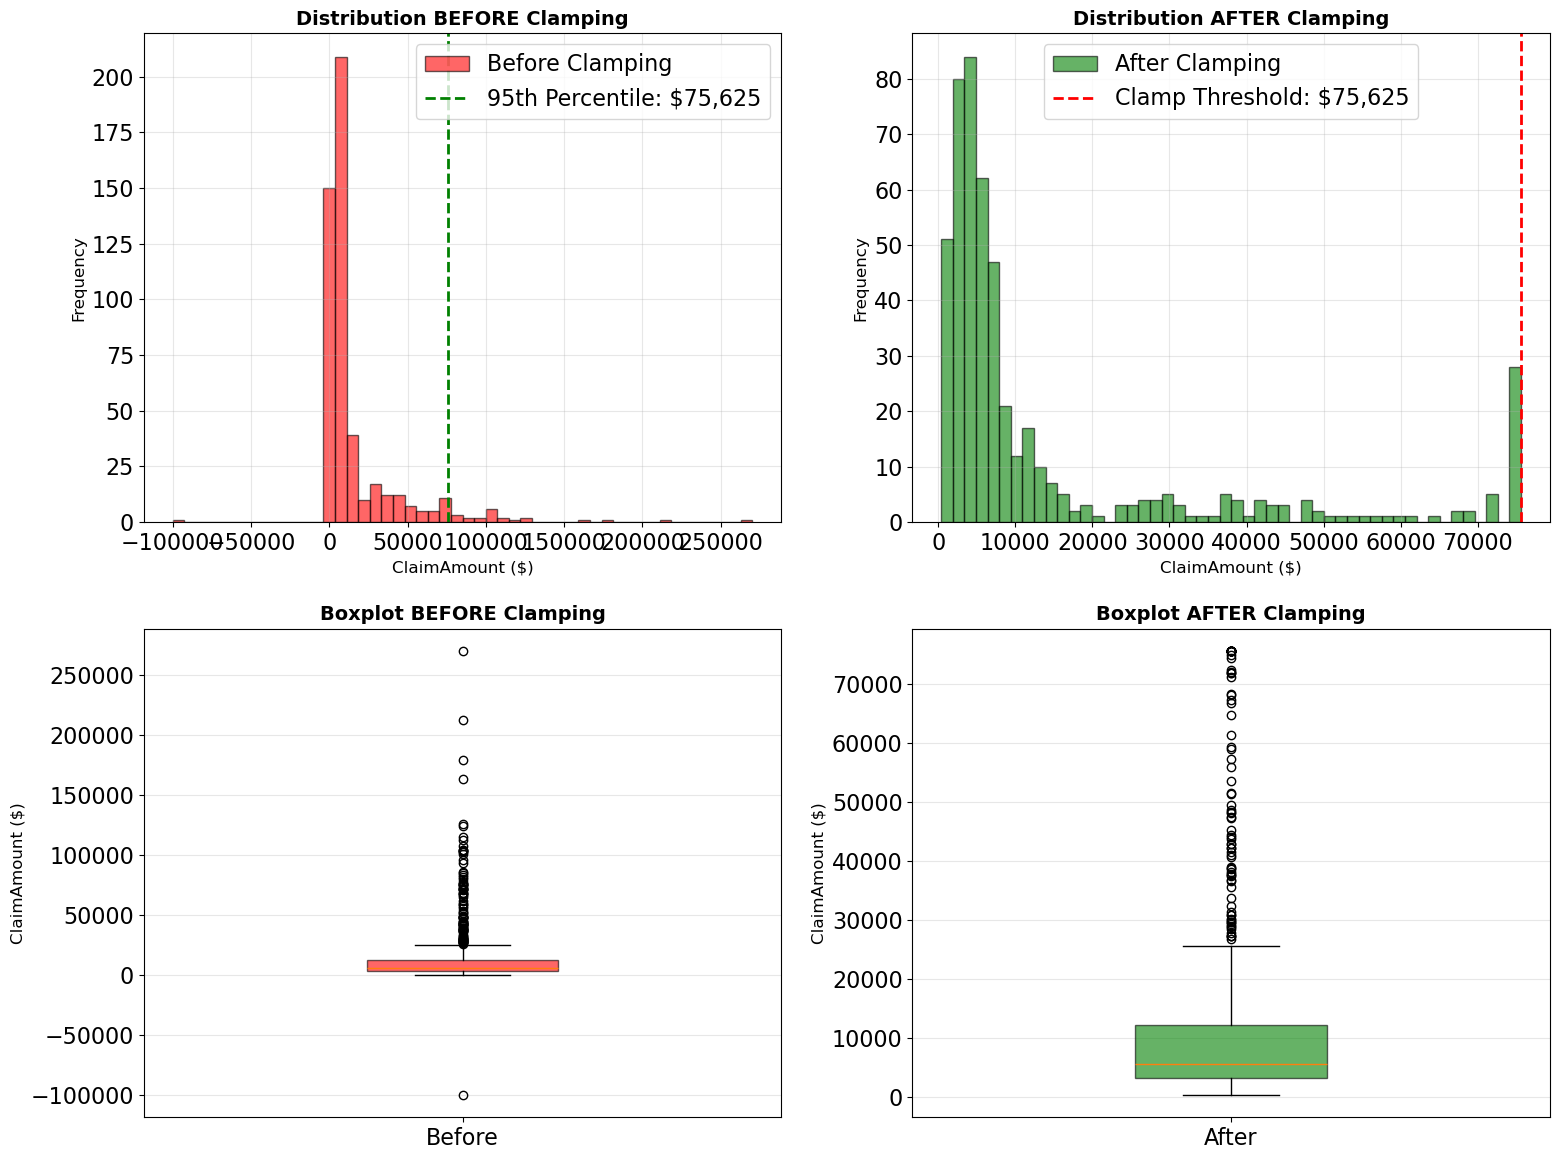

✓ Comparison visualization saved as 'ClaimAmount-Comparison-Before-After-Clamping.pdf'


In [ ]:
# Visualization: Side-by-side comparison of distributions

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histograms
ax = axes[0, 0]
ax.hist(claim_before, bins=50, alpha=0.6, label='Before Clamping', color='red', edgecolor='black')
ax.axvline(threshold_95, color='green', linestyle='--', linewidth=2, label=f'95th Percentile: ${threshold_95:,.0f}')
ax.set_xlabel('ClaimAmount ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution BEFORE Clamping', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[0, 1]
ax.hist(claim_after, bins=50, alpha=0.6, label='After Clamping', color='green', edgecolor='black')
ax.axvline(threshold_95, color='red', linestyle='--', linewidth=2, label=f'Clamp Threshold: ${threshold_95:,.0f}')
ax.set_xlabel('ClaimAmount ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution AFTER Clamping', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. Boxplots
ax = axes[1, 0]
bp1 = ax.boxplot(claim_before, vert=True, patch_artist=True, widths=0.3)
bp1['boxes'][0].set_facecolor('red')
bp1['boxes'][0].set_alpha(0.6)
ax.set_ylabel('ClaimAmount ($)', fontsize=12)
ax.set_title('Boxplot BEFORE Clamping', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.set_xticklabels(['Before'])

ax = axes[1, 1]
bp2 = ax.boxplot(claim_after, vert=True, patch_artist=True, widths=0.3)
bp2['boxes'][0].set_facecolor('green')
bp2['boxes'][0].set_alpha(0.6)
ax.set_ylabel('ClaimAmount ($)', fontsize=12)
ax.set_title('Boxplot AFTER Clamping', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='y')
ax.set_xticklabels(['After'])

plt.tight_layout()
plt.savefig('ClaimAmount-Comparison-Before-After-Clamping.pdf', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Comparison visualization saved as 'ClaimAmount-Comparison-Before-After-Clamping.pdf'")
